# Steepest Descent minimiser

Notebook showing how to use the implementation of an optimised version of the Steepest Descent (SD) algorithm in Fidimag, for an atomistic system.

This SD algorithm is based on Exl et al. Journal of Applied Physics 115, 17D118 (2014) https://aip.scitation.org/doi/10.1063/1.4862839

The following links are also relevant:

- MuMax3 code: https://github.com/mumax/3/blob/master/engine/minimizer.go
- The `minimizer` branch of Micromagnum: https://github.com/MicroMagnum/MicroMagnum/tree/minimizer/src/magnum/micromagnetics (here you can find conditions for the step sizes in Exl's publication)

The SD driver inherits from the `minimiser` base class in `fidimag/common/` and can be specified in the `driver` option of the `Simulation` class

In [1]:
import matplotlib.pyplot as plt
import fidimag
import fidimag.common.constant as C
import numpy as np
%matplotlib inline

In [2]:
# import imp
# imp.reload(fidimag)

## 1D example

We start defining parameters for an atomistic simulation

In [3]:
# System parameters
L = 100

# Some atomistic parameters
J = 5.88 * C.meV
D = 1.56 * C.meV
Ku = 0.41 * C.meV
mus = 3 * C.mu_B

# Lattice constants (in nm)
a = 0.2715
az = 0.408

# Magnetic field in Tesla
B = 2

# Free electron gyrom ratio
gamma = 1.76e11


Define the mesh of the system

In [4]:
nx, ny, nz = 100, 1, 1
dx, dy, dz = a, a, az

mesh = fidimag.common.CuboidMesh(nx=nx, ny=ny, nz=nz, dx=dx, dy=dy, dz=dz, 
                                periodicity=(False, False, False),
                                unit_length=1e-9)


### Steepest Descent

Here we set the minimiser by specifying it in the `driver` argument in the Simulation class:

In [5]:
sim = fidimag.atomistic.Sim(mesh, name='one_dim_SD', driver='steepest_descent')
       
# Define the magnetisation
sim.set_mu_s(mus)

# Add the magnetic interactions
sim.add(fidimag.atomistic.Exchange(J))
sim.add(fidimag.atomistic.Anisotropy(Ku, axis=(0, 0, 1)))
sim.add(fidimag.atomistic.DMI(D, dmi_type='interfacial'))
sim.add(fidimag.atomistic.Zeeman((0, 0, B)))

xs = mesh.coordinates[:, 0]
centre_x = (xs.max() + xs.min()) * 0.5 + xs.min() 
       
def m_initial(r):
    x, y, z = r[0], r[1], r[2]
    if np.abs(x - centre_x) < 2:
        return (0, 0.1, -.9)
    else:
        return (0, 0.1, .9)

# sim.set_m((0.1, 0, 0.9))
sim.set_m(m_initial)

The initial configuration showing $m_{z}$, we want a domain wall after relaxation:

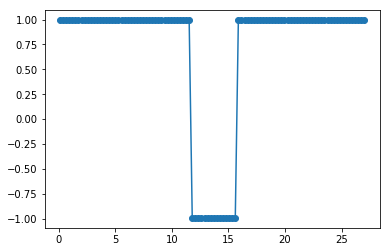

In [6]:
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 2], 'o-')

Here we relax the system with the steepest descent. In this case, the relevant parameter to stop the minimisation is the `dm` difference of the magnetisation with the previous step:

In [7]:
sim.driver.tmax = 1e-1
sim.driver.minimise(max_steps=20000, stopping_dm=1e-10, initial_t_step=1e-2)

#max_tau=0.01     max_dm=0.191      counter=0
FINISHED AT: max_tau=0.01     max_dm=9.75e-11   counter=711


The performance of the algorithm can be tuned by modifying the `tmax` and `tmin` tolerances in the driver. By defalt, `tmax` is around 0.01 (MuMax3 uses this magnitude) and `tmin` must be significantly small. These values seem to work reasonably well for most atomistic simulations:

In [8]:
# sim.driver.tmax = 
# sim.driver.tmin =

We finally obtain the $360^\circ$ domain wall:

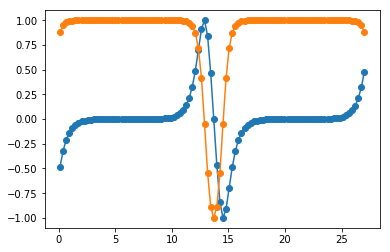

In [9]:
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 0], 'o-')
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 2], 'o-')

### LLG

We can compare the previous result with the LLG driver, which is widely tested:

In [10]:
sim = fidimag.atomistic.Sim(mesh, name='one_dim', driver='llg')
       
# Define the magnetisation
sim.set_mu_s(mus)

# Add the magnetic interactions
sim.add(fidimag.atomistic.Exchange(J))
sim.add(fidimag.atomistic.Anisotropy(Ku, axis=(0, 0, 1)))
sim.add(fidimag.atomistic.DMI(D, dmi_type='interfacial'))
sim.add(fidimag.atomistic.Zeeman((0, 0, B)))

xs = mesh.coordinates[:, 0]
centre_x = (xs.max() + xs.min()) * 0.5 + xs.min() 
       
def m_initial(r):
    x, y, z = r[0], r[1], r[2]
    if np.abs(x - centre_x) < 2:
        return (0, 0.1, -.9)
    else:
        return (0, 0.1, .9)

# sim.set_m((0.1, 0, 0.9))
sim.set_m(m_initial)

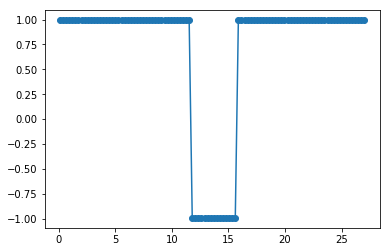

In [11]:
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 2], 'o-')

In [12]:
sim.driver.do_precession = False
sim.relax()

#1    t=1e-11    dt=1e-11 max_dmdt=1.77
#2    t=3.53e-10 dt=3.43e-10 max_dmdt=1.77
#3    t=3.79e-09 dt=3.43e-09 max_dmdt=1.77
#4    t=3.81e-08 dt=3.43e-08 max_dmdt=1.77
#5    t=3.81e-07 dt=3.43e-07 max_dmdt=1.77
#6    t=3.81e-06 dt=3.43e-06 max_dmdt=1.77
#7    t=2.51e-05 dt=2.13e-05 max_dmdt=1.77
#8    t=8.19e-05 dt=5.67e-05 max_dmdt=1.77
#9    t=0.000197 dt=0.000115 max_dmdt=1.77
#10   t=0.000417 dt=0.00022 max_dmdt=1.77
#11   t=0.000637 dt=0.00022 max_dmdt=1.77
#12   t=0.000856 dt=0.00022 max_dmdt=1.77
#13   t=0.00108  dt=0.00022 max_dmdt=1.77
#14   t=0.00161  dt=0.000532 max_dmdt=1.78
#15   t=0.00214  dt=0.000532 max_dmdt=1.78
#16   t=0.00267  dt=0.000532 max_dmdt=1.78
#17   t=0.0032   dt=0.000532 max_dmdt=1.78
#18   t=0.00374  dt=0.000532 max_dmdt=1.79
#19   t=0.00483  dt=0.00109 max_dmdt=1.79
#20   t=0.00591  dt=0.00109 max_dmdt=1.8
#21   t=0.007    dt=0.00109 max_dmdt=1.8
#22   t=0.00809  dt=0.00109 max_dmdt=1.81
#23   t=0.00918  dt=0.00109 max_dmdt=1.82
#24   t=0.0109   dt=0.001

#286  t=11.4     dt=0.179 max_dmdt=0.0742
#287  t=11.6     dt=0.179 max_dmdt=0.0714
#288  t=11.8     dt=0.179 max_dmdt=0.0685
#289  t=12       dt=0.179 max_dmdt=0.0658
#290  t=12.2     dt=0.179 max_dmdt=0.0631
#291  t=12.3     dt=0.179 max_dmdt=0.0605
#292  t=12.5     dt=0.179 max_dmdt=0.0579
#293  t=12.7     dt=0.179 max_dmdt=0.0554
#294  t=12.9     dt=0.179 max_dmdt=0.053
#295  t=13       dt=0.179 max_dmdt=0.0506
#296  t=13.2     dt=0.179 max_dmdt=0.0484
#297  t=13.4     dt=0.179 max_dmdt=0.0462
#298  t=13.6     dt=0.179 max_dmdt=0.0441
#299  t=13.8     dt=0.179 max_dmdt=0.042
#300  t=13.9     dt=0.179 max_dmdt=0.0401
#301  t=14.1     dt=0.179 max_dmdt=0.0382
#302  t=14.3     dt=0.179 max_dmdt=0.0364
#303  t=14.5     dt=0.179 max_dmdt=0.0347
#304  t=14.7     dt=0.179 max_dmdt=0.033
#305  t=14.8     dt=0.179 max_dmdt=0.0314
#306  t=15       dt=0.179 max_dmdt=0.0299
#307  t=15.2     dt=0.179 max_dmdt=0.0285
#308  t=15.4     dt=0.179 max_dmdt=0.0272
#309  t=15.6     dt=0.179 max_dmdt=0.

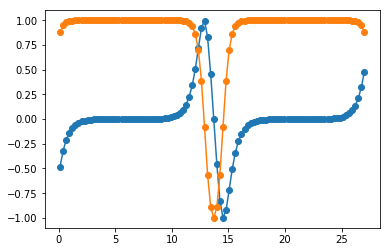

In [13]:
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 0], 'o-')
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 2], 'o-')

## 2D skyrmion

A more complex example is a 2D skyrmion in a disk. We will use the minimiser to find the equilibrium state:

In [10]:
nx, ny, nz = 100, 100, 1
dx, dy, dz = a, a, az

mesh = fidimag.common.CuboidMesh(nx=nx, ny=ny, nz=nz, dx=dx, dy=dy, dz=dz, 
                                periodicity=(False, False, False),
                                unit_length=1e-9)
xs = mesh.coordinates[:, 0]
ys = mesh.coordinates[:, 1]
centre_x = (xs.max() + xs.min()) * 0.5 + xs.min() 

### LLG

We start finding the solution with the LLG driver:

In [11]:
sim = fidimag.atomistic.Sim(mesh, name='two_dim', driver='llg')
       
# Define the magnetisation
def material(r):
    x, y = r[0] - centre_x, r[1] - centre_x
    
    if x ** 2 + y ** 2 < (np.max(xs) - centre_x) ** 2:
        return mus
    else:
        return 0
    
sim.set_mu_s(material)
# sim.set_mu_s(mus)

# Add the magnetic interactions
sim.add(fidimag.atomistic.Exchange(J))
sim.add(fidimag.atomistic.Anisotropy(Ku, axis=(0, 0, 1)))
sim.add(fidimag.atomistic.DMI(D, dmi_type='interfacial'))
sim.add(fidimag.atomistic.Zeeman((0, 0, B)))
    
def m_initial(r):
    x, y = r[0] - centre_x, r[1] - centre_x
    if x ** 2 + y ** 2 < 1 ** 2:
        return (0, 0, -1)
    else:
        return (0, 0, 1)

sim.set_m(m_initial)
# sim.set_m((0, 0, 1))

The initial configuration with a dot at the centre of the sample:

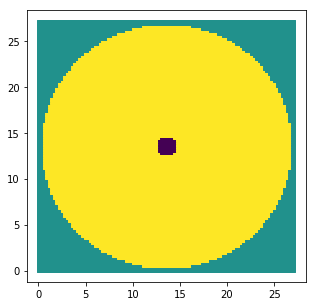

In [12]:
plt.figure(figsize=(5, 5))
plt.scatter(xs, ys, c=sim.spin.reshape(-1, 3)[:, 2], s=20, marker='s')

In [13]:
%%capture
sim.driver.do_precession = False
sim.driver.relax()

After relaxation we see a skyrmion and the spin tilting at the boundary, characteristic of the DMI

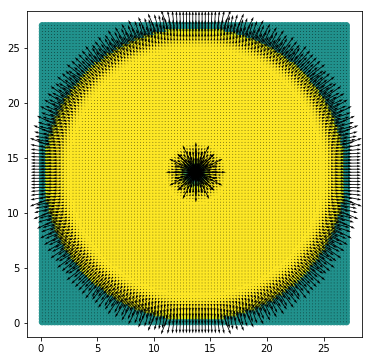

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(xs, ys, c=sim.spin.reshape(-1, 3)[:, 2], vmin=-1, vmax=1)

plt.quiver(xs, ys, sim.spin.reshape(-1, 3)[:, 0], sim.spin.reshape(-1, 3)[:, 1])

### Steepest Descent

We can get the same result using the minimiser:

In [16]:
sim = fidimag.atomistic.Sim(mesh, name='two_dim_SD', driver='steepest_descent')
       
# Define the magnetisation
def material(r):
    x, y = r[0] - centre_x, r[1] - centre_x
    
    if x ** 2 + y ** 2 < (np.max(xs) - centre_x) ** 2:
        return mus
    else:
        return 0
    
sim.set_mu_s(material)
# sim.set_mu_s(mus)

# Add the magnetic interactions
sim.add(fidimag.atomistic.Exchange(J))
sim.add(fidimag.atomistic.Anisotropy(Ku, axis=(0, 0, 1)))
sim.add(fidimag.atomistic.DMI(D, dmi_type='interfacial'))
sim.add(fidimag.atomistic.Zeeman((0, 0, B)))
       
def m_initial(r):
    x, y = r[0] - centre_x, r[1] - centre_x
    if x ** 2 + y ** 2 < 1:
        return (0, 0, -1)
    else:
        return (0, 0, 1)

sim.set_m(m_initial)
# sim.set_m((0, 0, 1))

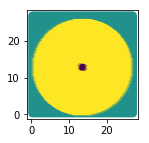

In [17]:
plt.figure(figsize=(2, 2))
plt.scatter(xs, ys, c=sim.spin.reshape(-1, 3)[:, 2])

In [18]:
sim.driver.tmax = 1e-1
sim.driver.minimise(max_steps=5000, stopping_dm=1e-11, initial_t_step=1e-4)

#max_tau=0.0001   max_dm=0.00254    counter=0
#max_tau=0.0001   max_dm=0.000413   counter=1000
#max_tau=0.0001   max_dm=0.000109   counter=2000
#max_tau=0.0001   max_dm=6.32e-05   counter=3000
#max_tau=0.0001   max_dm=4.88e-05   counter=4000


In [19]:
sim.driver.spin.shape

(30000,)

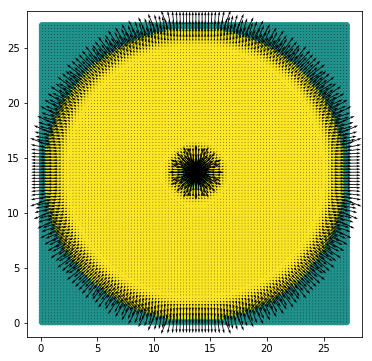

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(xs, ys, c=sim.spin.reshape(-1, 3)[:, 2], vmin=-1, vmax=1)

plt.quiver(xs, ys, sim.spin.reshape(-1, 3)[:, 0], sim.spin.reshape(-1, 3)[:, 1])